In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
df_base = pd.read_csv('baseline.csv')
df_base

,PATIENTID,site,age,bmi,CUPE,location,spesi,rvlv_rat,biomarkers,dyspnea,lytics_contra,hx_pe,hx_dvt,cur_dvt
0,watwnk53tw,5,65.051335,36.54,Submassive (Intermediate Risk),saddle,2.0,1.300000,Yes,3,No,No,No,Yes
1,tmijs14kit,3,66.239562,39.00,Submassive (Intermediate Risk),<undefined>,NaN,NaN,Yes,Not done,Absolute,No,No,No
2,sur8nd7ojz,6,62.417522,33.19,Submassive (Intermediate Risk),saddle,2.0,2.910053,Yes,<undefined>,No,Yes,No,No
3,1uw7qeu5gb,19,72.736482,25.96,Massive (High Risk),saddle,1.0,NaN,Yes,Not done,No,No,No,No
4,xq1rhscbk3,27,69.399042,41.45,Massive (High Risk),bilateral,2.0,1.864238,Yes,4,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,m0nf34utcx,3,63.030801,25.41,Submassive (Intermediate Risk),saddle,3.0,1.090909,Yes,4,Relative,No,No,Yes
321,vqvwn7zujb,3,35.630390,32.97,Submassive (Intermediate Risk),bilateral,2.0,1.133333,Yes,Not done,No,No,No,No
322,mmgnq3di5d,3,52.662560,26.09,Submassive (Intermediate Risk),bilateral,3.0,1.555556,Yes,3,Relative,No,No,Yes
323,e20pudq5wi,2,79.019849,35.23,Submassive (Intermediate Risk),saddle,2.0,NaN,Yes,0,Relative,No,No,Yes


    PATIENTID: Unique identifier for each enrolled registry subject
    site: Unique identifier for each registry site at which patient is enrolled
    age: Calculated age of patient at time of procedure, based on birth date
    bmi: Body mass index
    CUPE: Clot-related stratification (Submassive or Massive) - Massive and Submassive refer to the AHA classification system, relating generally to symptom, hemodynamic compromise, RV strain, and elevated biomarkers
    location: Clot location - unilateral, bilateral, saddle (straddles the bifurcation of the pulmonary trunk extending to the left and right pulmonary arteries)
    spesi: Simplified PESI (Pulmonary Embolism Severity Index)
    rvlv_rat: RV/LV ratio - RV dilatation as a proxy for RV dysfunction can be assessed by calculating the right-to-left ventricle diameter (RV/LV) ratio
    biomarkers: Positive for Biomarkers ("true" if at least one of troponin or BNP)
    dyspnea: Pre-FT dyspnea score, mMRC scale
    lytics_contra: Lytics contraindication (Absolute, Relative, No)
    hx_pe: History of prior PE
    hx_dvt: History of DVT
    cur_dvt: Currently has DVT (may be diagnosed at screening for example, or otherwise recognized at the index hospitalization)

In [3]:
df_proce = pd.read_csv('procedure.csv')
df_proce

,PATIENTID,proc_time,cath_time,fluoro_time,T20,Disks,missing
0,2vzk3y1v75,113.0,94.0,35.8,1,1,0
1,jpxum9mn5j,56.0,29.0,20.6,1,1,0
2,l07jpabz3r,55.0,40.0,16.6,1,1,0
3,gpvgmp80p7,63.0,46.0,20.5,1,1,0
4,8l9ryi12wu,65.0,45.0,19.8,1,0,0
...,...,...,...,...,...,...,...
320,umn5nd422p,55.0,37.0,17.9,1,0,0
321,bnhxtaajnj,NaN,NaN,NaN,0,0,0
322,23z27gui8y,39.0,38.0,14.2,0,0,0
323,apze8o5kfm,40.0,33.0,23.0,0,0,1


    PATIENTID:Unique identifier for each enrolled registry subject
    proc_time: Time from venous access to last catheter removal,total procedure time
    cath_time: Time from catheter insertion (not guidewire) to last catheter removal, total time catheter inside patient body
    fluoro_time：Total fluoroscopy time (physician look at patient lung image)
    T20: See "Data Extract Overview" tab. Note that T20 Curve was not included in this study.  T20 and T24 are both Aspiration catheters (as opposed to the "FlowTriever Catheter" aka "Disks") (There is also a T16 catheter that we are not concerned with here--it is used in some procedures but those data aren't included in this extract)
    Disks: FlowTriever disks deployed (Only Gen1 was part of this study)
    missing: See "Data Extract Overview" tab

In [4]:
df = pd.merge(df_base, df_proce, on="PATIENTID")
df = df[['location','proc_time','cath_time','fluoro_time','T20','Disks','missing']]
df.head()

,location,proc_time,cath_time,fluoro_time,T20,Disks,missing
0,saddle,82.0,60.0,34.55,1,0,0
1,<undefined>,80.0,33.0,26.00,0,0,1
2,saddle,99.0,89.0,20.00,0,0,1
3,saddle,NaN,47.0,19.50,0,0,0
4,bilateral,62.0,37.0,12.80,0,0,0


In [5]:
df.describe()

,proc_time,cath_time,fluoro_time,T20,Disks,missing
count,296.000000,298.000000,314.000000,325.000000,325.000000,325.000000
mean,76.831081,44.208054,24.117675,0.430769,0.098462,0.387692
std,32.593623,84.874459,11.144898,0.495947,0.298397,0.487975
min,18.000000,-1335.000000,4.500000,0.000000,0.000000,0.000000
25%,55.000000,30.000000,16.000000,0.000000,0.000000,0.000000
50%,72.000000,44.000000,21.765000,0.000000,0.000000,0.000000
75%,91.000000,61.000000,30.675000,1.000000,0.000000,1.000000
max,237.000000,175.000000,72.100000,1.000000,1.000000,1.000000


In [6]:
# percentage of missing value in each column
100* df.isnull().sum() / len(df)

location       0.000000
proc_time      8.923077
cath_time      8.307692
fluoro_time    3.384615
T20            0.000000
Disks          0.000000
missing        0.000000
dtype: float64

In [7]:
# drop missing values
df = df.dropna()
df.shape

(288, 7)

<AxesSubplot:>

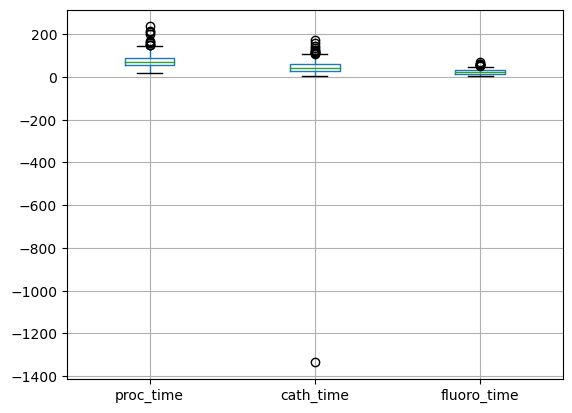

In [8]:
# check for distribution and outliers
df.boxplot(column = ['proc_time','cath_time','fluoro_time'])

In [9]:
# drop the cath time below 0 because it is not possible for a time to be negative, maybe due to data entry typo
df = df[df['cath_time']>0]
df.shape

(287, 7)

## Location Variable

In [10]:
df['location'].value_counts()

bilateral      142
saddle         114
unilateral      30
<undefined>      1
Name: location, dtype: int64

In [11]:
# drop the undefined missing value record
df = df[df['location']!='<undefined>']
df.shape

(286, 7)

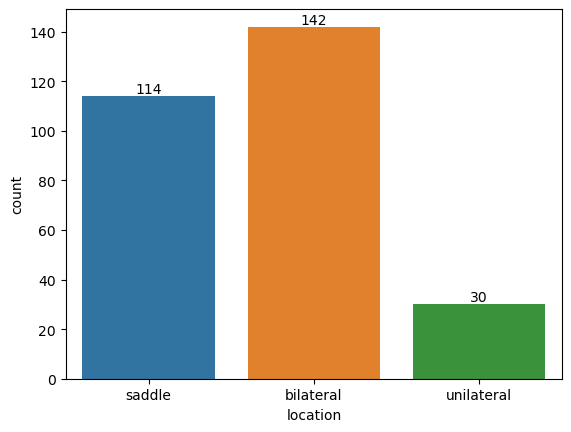

In [12]:
# found the location target variable extremely imbalanced
ax = sns.countplot(data = df, x ='location')
ax.bar_label(ax.containers[0]);

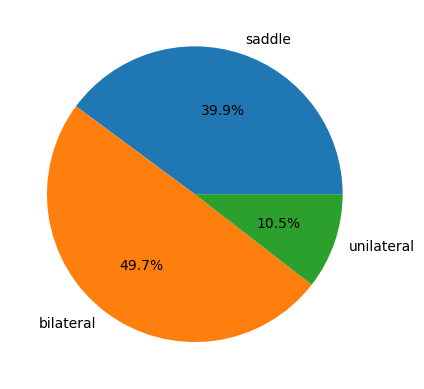

In [13]:
fig, ax = plt.subplots()
ax.pie((114,142,30), labels=('saddle', 'bilateral', 'unilateral'), autopct='%1.1f%%')
plt.show()

## Oversampling using SMOTE Technique

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X, y = df[['proc_time','cath_time','fluoro_time']], df['location']
X_smote, y_smote= smote.fit_resample(X, y)  # use smote to resample the dataset features and target
df_smote = pd.concat([X_smote, y_smote], axis=1)  # concatenate features and target to df_smote
df_smote = df_smote.sample(frac=1).reset_index(drop=True)  # shuffle the entire dataframe

In [15]:
df_smote.shape

(426, 4)

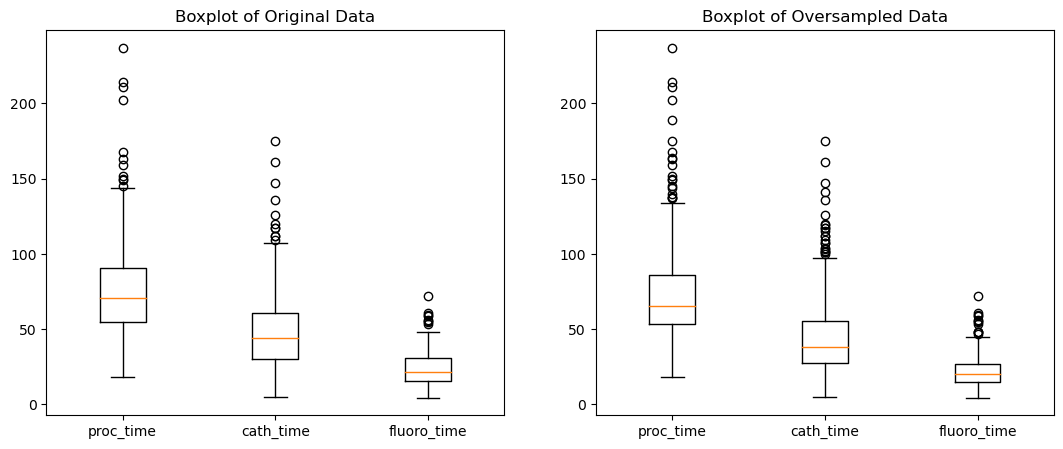

In [16]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
axes[0].boxplot(df[['proc_time','cath_time','fluoro_time']])
axes[0].set_title('Boxplot of Original Data')
axes[0].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time'])
axes[1].boxplot(df_smote[['proc_time','cath_time','fluoro_time']])
axes[1].set_title('Boxplot of Oversampled Data')
axes[1].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time']);

In [17]:
q75_1, q25_1 = np.percentile(df_smote['proc_time'], [75 ,25])
iqr_1 = q75_1 - q25_1
q75_2, q25_2 = np.percentile(df_smote['cath_time'], [75 ,25])
iqr_2 = q75_2 - q25_2
q75_3, q25_3 = np.percentile(df_smote['fluoro_time'], [75 ,25])
iqr_3 = q75_3 - q25_3

In [18]:
df_smote2 = df_smote[(df_smote['proc_time'] < q75_1+1.5*iqr_1) & (df_smote['cath_time'] < q75_2+1.5*iqr_2)
                    &(df_smote['fluoro_time'] < q75_3+1.5*iqr_3)]
df_smote2.shape

(395, 4)

In [19]:
df_outliers = df_smote[(df_smote['proc_time'] >= q75_1+1.5*iqr_1)|(df_smote['cath_time'] >= q75_2+1.5*iqr_2)|
                      (df_smote['fluoro_time'] >= q75_3+1.5*iqr_3)]
df_outliers.shape

(31, 4)

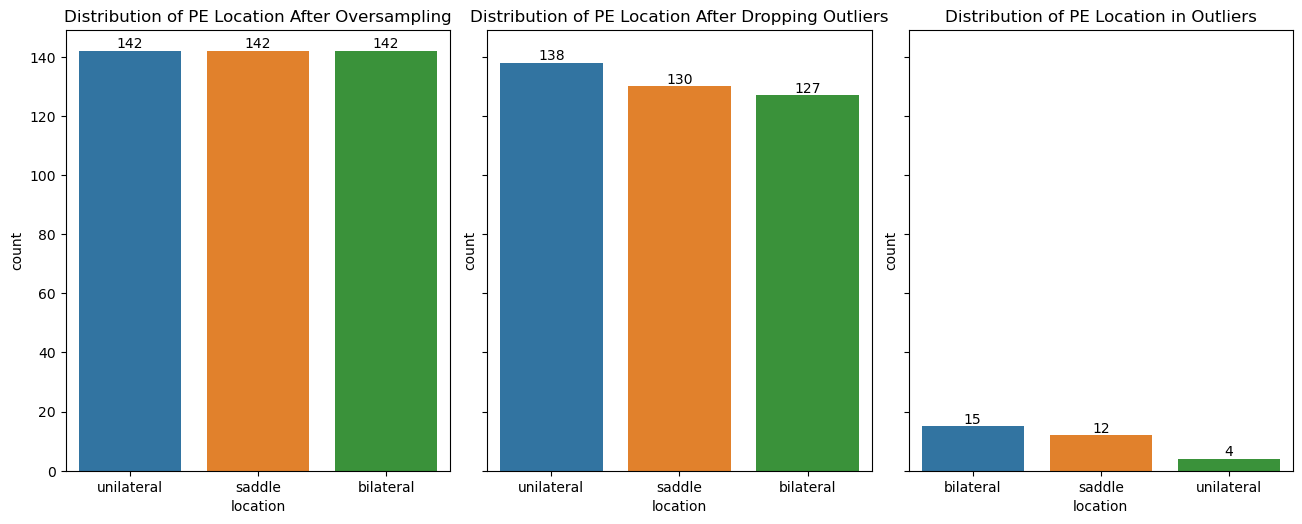

In [20]:
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.countplot(data =df_smote, x ='location', ax=ax[0]).set(title='Distribution of PE Location After Oversampling')
ax[0].bar_label(ax[0].containers[0])
sns.countplot(data =df_smote2, x ='location', ax=ax[1]).set(title='Distribution of PE Location After Dropping Outliers')
ax[1].bar_label(ax[1].containers[0])
sns.countplot(data =df_outliers, x ='location', ax=ax[2]).set(title='Distribution of PE Location in Outliers')
ax[2].bar_label(ax[2].containers[0]);

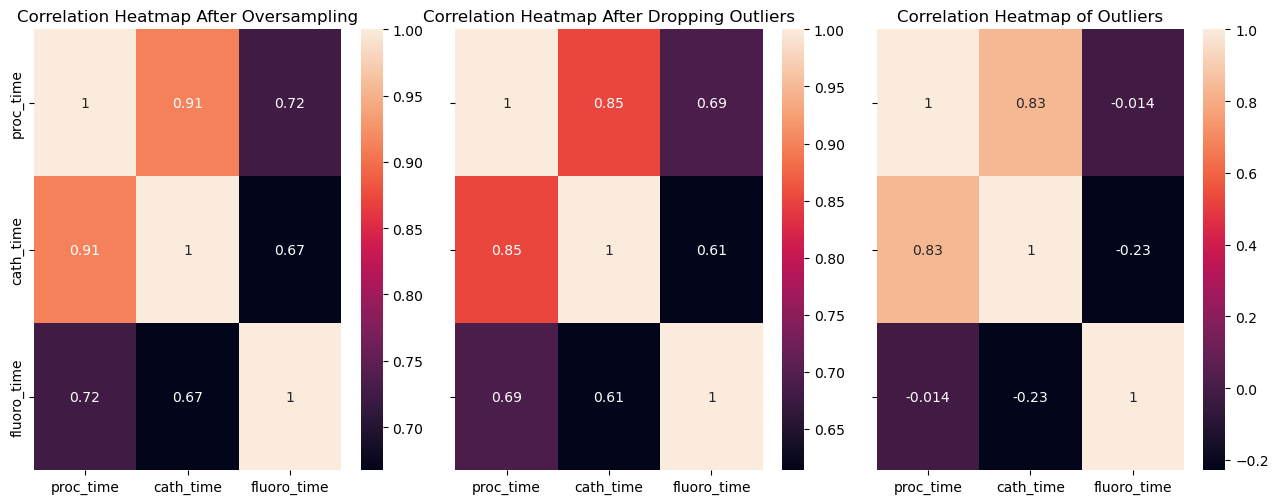

In [21]:
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.heatmap(df_smote.corr(),annot=True, ax=ax[0]).set(title='Correlation Heatmap After Oversampling')
sns.heatmap(df_smote2.corr(),annot=True, ax=ax[1]).set(title='Correlation Heatmap After Dropping Outliers')
sns.heatmap(df_outliers.corr(),annot=True, ax=ax[2]).set(title='Correlation Heatmap of Outliers');

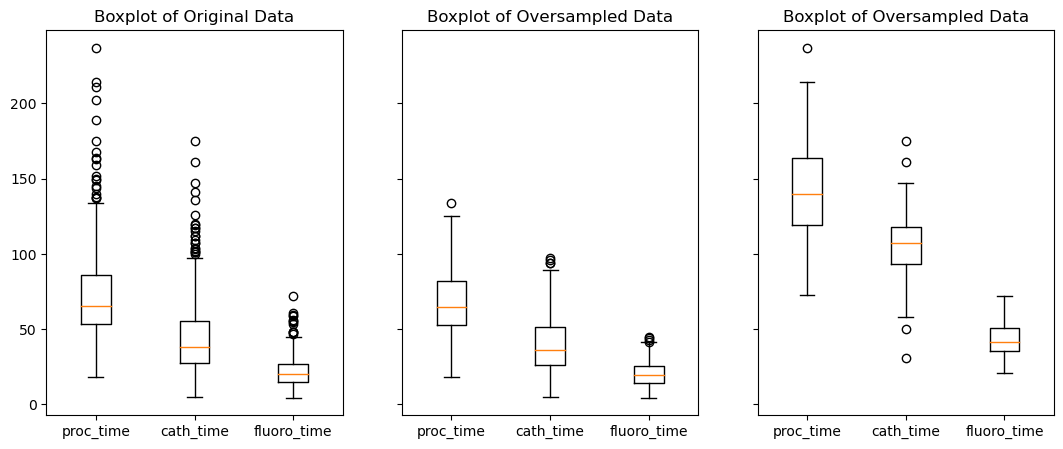

In [22]:
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
axes[0].boxplot(df_smote[['proc_time','cath_time','fluoro_time']])
axes[0].set_title('Boxplot of Original Data')
axes[0].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time'])
axes[1].boxplot(df_smote2[['proc_time','cath_time','fluoro_time']])
axes[1].set_title('Boxplot of Oversampled Data')
axes[1].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time'])
axes[2].boxplot(df_outliers[['proc_time','cath_time','fluoro_time']])
axes[2].set_title('Boxplot of Oversampled Data')
axes[2].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time']);

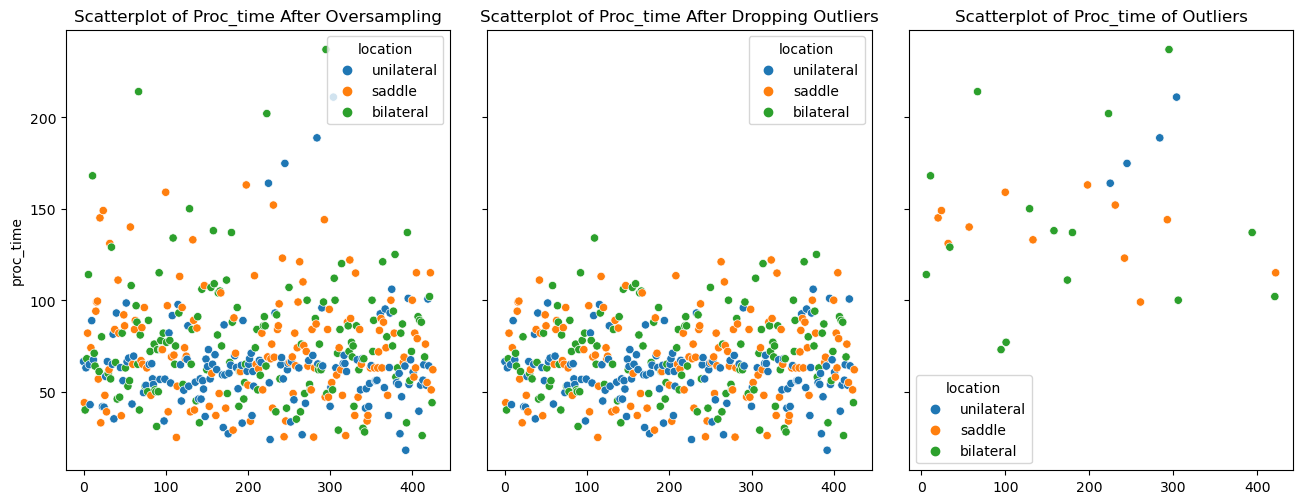

In [23]:
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.scatterplot(data=df_smote, x=df_smote.index, y='proc_time',hue='location',ax=ax[0]).set(title='Scatterplot of Proc_time After Oversampling')
sns.scatterplot(data=df_smote2, x=df_smote2.index, y='proc_time',hue='location',ax=ax[1]).set(title='Scatterplot of Proc_time After Dropping Outliers')
sns.scatterplot(data=df_outliers, x=df_outliers.index, y='proc_time',hue='location',ax=ax[2],hue_order =['unilateral','saddle','bilateral']).set(title='Scatterplot of Proc_time of Outliers');

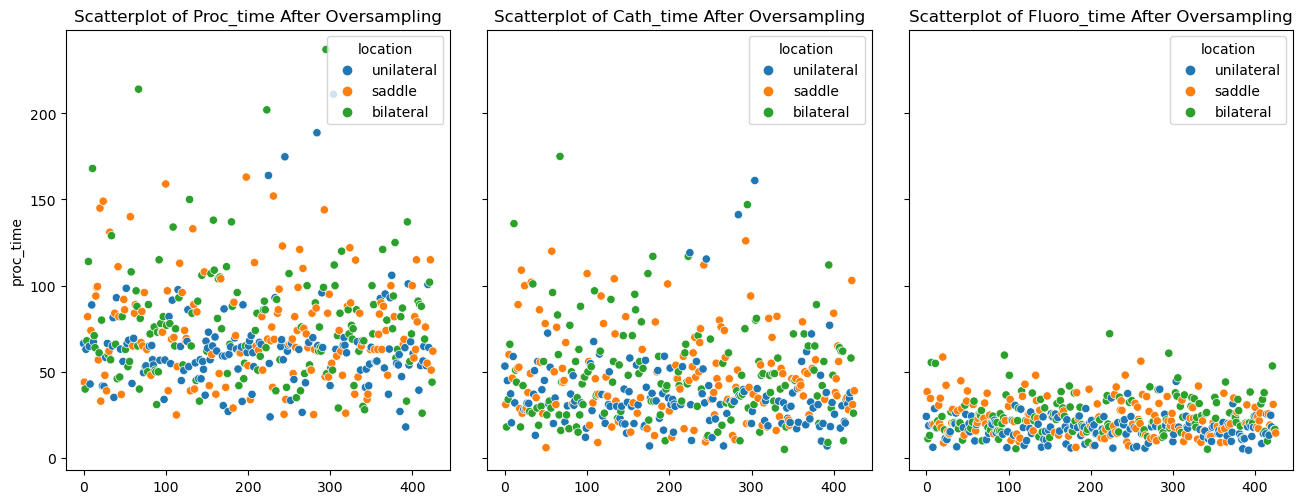

In [24]:
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.scatterplot(data=df_smote, x=df_smote.index, y='proc_time',hue='location',ax=ax[0]).set(title='Scatterplot of Proc_time After Oversampling')
sns.scatterplot(data=df_smote, x=df_smote.index, y='cath_time',hue='location',ax=ax[1]).set(title='Scatterplot of Cath_time After Oversampling')
sns.scatterplot(data=df_smote, x=df_smote.index, y='fluoro_time',hue='location',ax=ax[2],hue_order =['unilateral','saddle','bilateral']).set(title='Scatterplot of Fluoro_time After Oversampling');

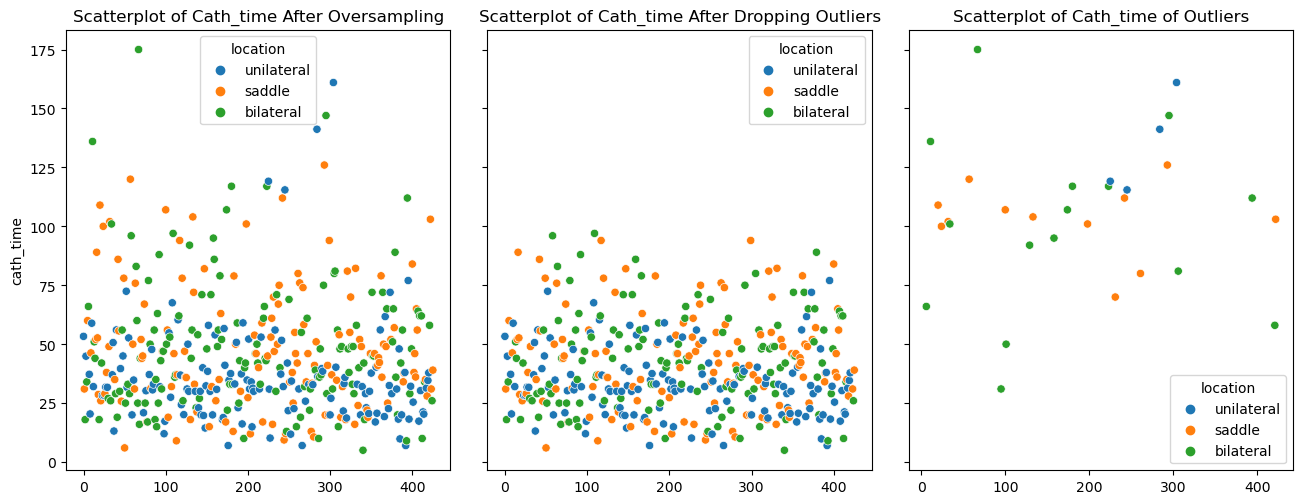

In [25]:
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.scatterplot(data=df_smote, x=df_smote.index, y='cath_time',hue='location',ax=ax[0]).set(title='Scatterplot of Cath_time After Oversampling')
sns.scatterplot(data=df_smote2, x=df_smote2.index, y='cath_time',hue='location',ax=ax[1]).set(title='Scatterplot of Cath_time After Dropping Outliers')
sns.scatterplot(data=df_outliers, x=df_outliers.index, y='cath_time',hue='location',ax=ax[2],hue_order =['unilateral','saddle','bilateral']).set(title='Scatterplot of Cath_time of Outliers');

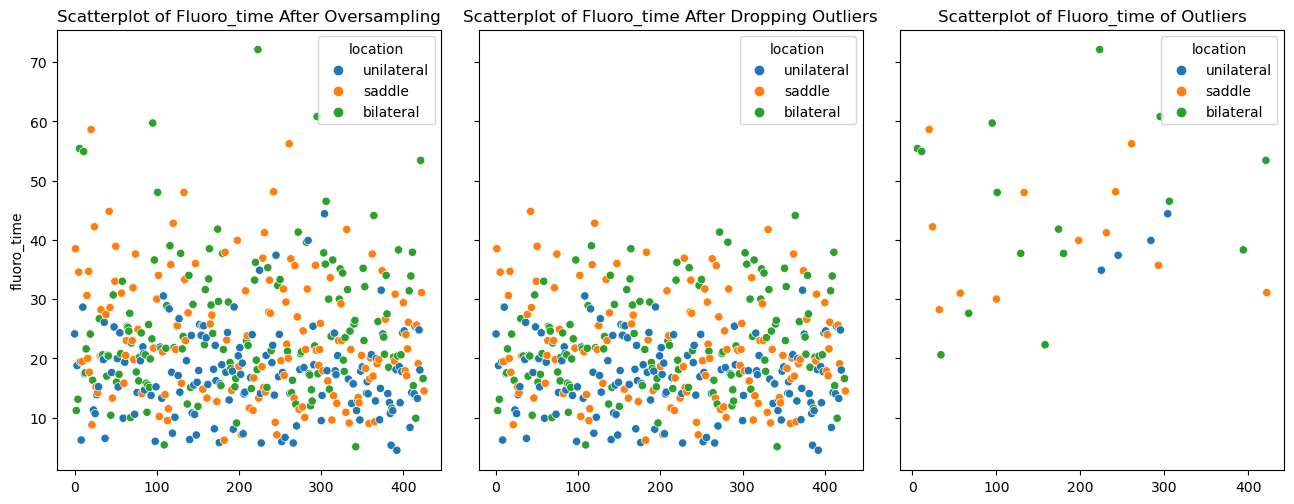

In [26]:
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.scatterplot(data=df_smote, x=df_smote.index, y='fluoro_time',hue='location',ax=ax[0]).set(title='Scatterplot of Fluoro_time After Oversampling')
sns.scatterplot(data=df_smote2, x=df_smote2.index, y='fluoro_time',hue='location',ax=ax[1]).set(title='Scatterplot of Fluoro_time After Dropping Outliers')
sns.scatterplot(data=df_outliers, x=df_outliers.index, y='fluoro_time',hue='location',ax=ax[2],hue_order =['unilateral','saddle','bilateral']).set(title='Scatterplot of Fluoro_time of Outliers');

### Analysis of df_smote

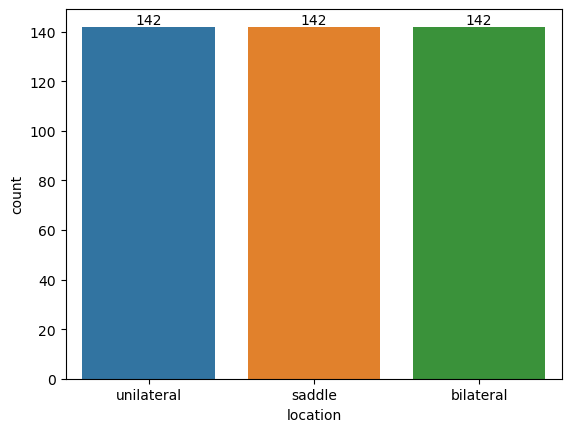

In [27]:
ax = sns.countplot(data = df_smote, x ='location')
ax.bar_label(ax.containers[0]);

<AxesSubplot:>

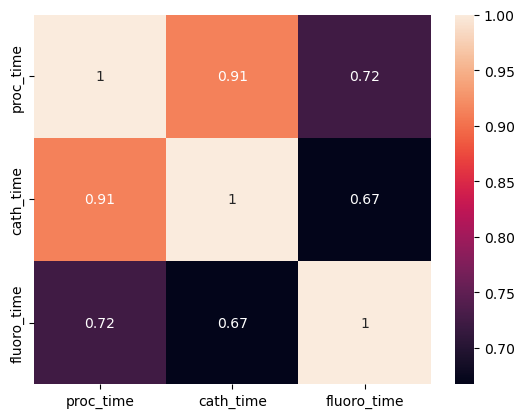

In [28]:
sns.heatmap(df_smote.corr(),annot=True)

<AxesSubplot:ylabel='cath_time'>

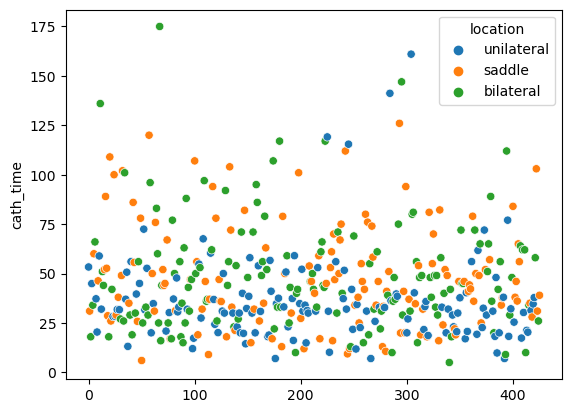

In [29]:
sns.scatterplot(data=df_smote, x=df_smote.index, y='cath_time',hue='location')

<AxesSubplot:ylabel='fluoro_time'>

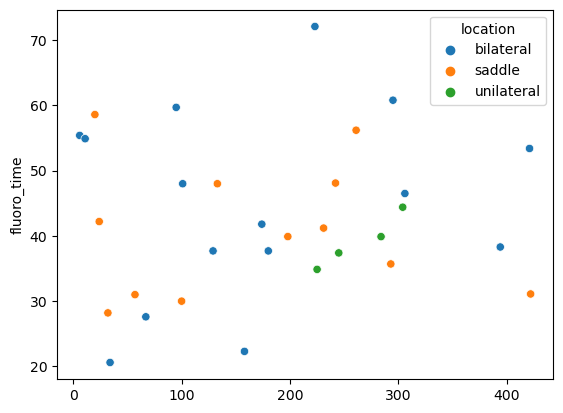

In [30]:
sns.scatterplot(data=df_outliers, x=df_outliers.index, y='fluoro_time',hue='location')

<AxesSubplot:ylabel='proc_time'>

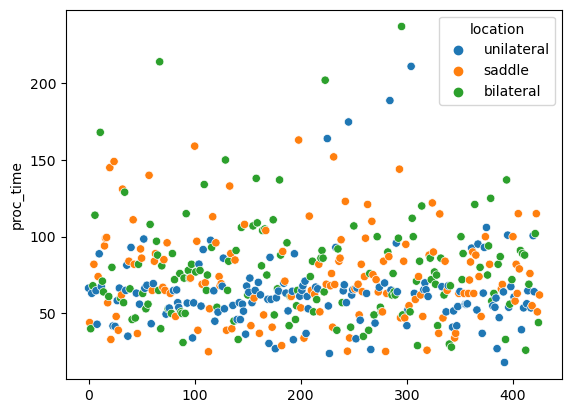

In [31]:
sns.scatterplot(data=df_smote, x=df_smote.index, y='proc_time',hue='location')

<AxesSubplot:ylabel='fluoro_time'>

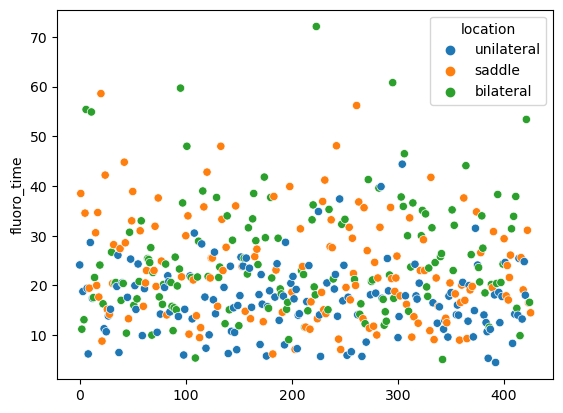

In [32]:
sns.scatterplot(data=df_smote, x=df_smote.index, y='fluoro_time',hue='location')

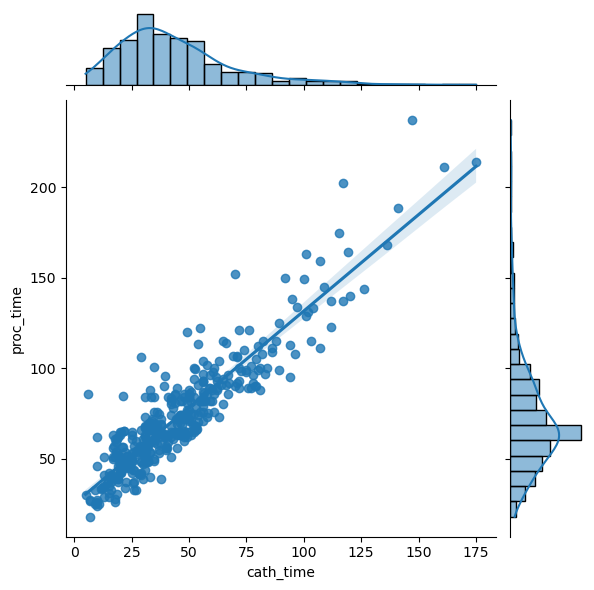

In [33]:
sns.jointplot(data=df_smote, x='cath_time', y='proc_time',kind='reg')

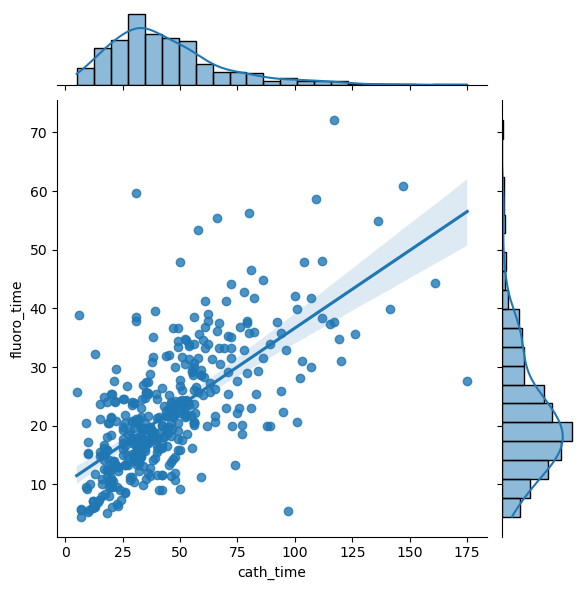

In [34]:
sns.jointplot(data=df_smote, x='cath_time', y='fluoro_time',kind='reg')

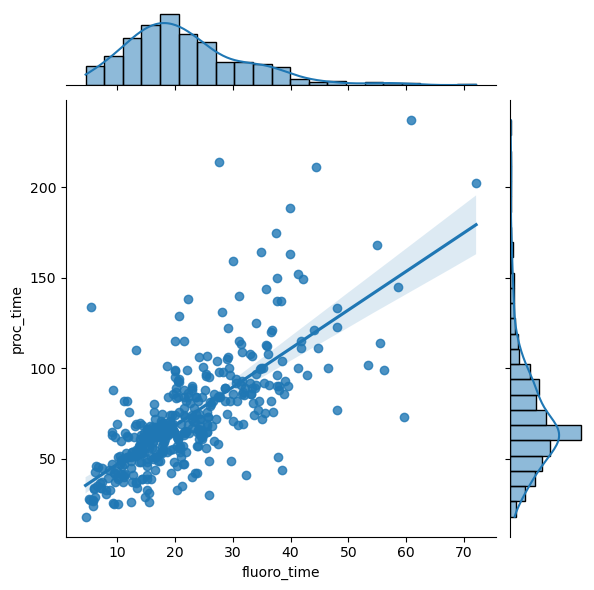

In [35]:
sns.jointplot(data=df_smote, x='fluoro_time', y='proc_time',kind='reg')

### Analysis of df_smote2

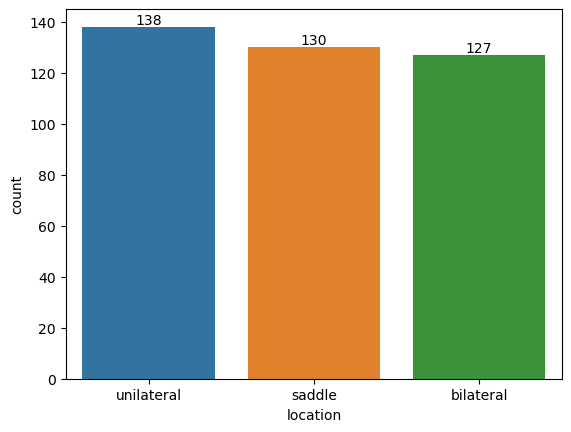

In [36]:
ax = sns.countplot(data = df_smote2, x ='location')
ax.bar_label(ax.containers[0]);

<AxesSubplot:>

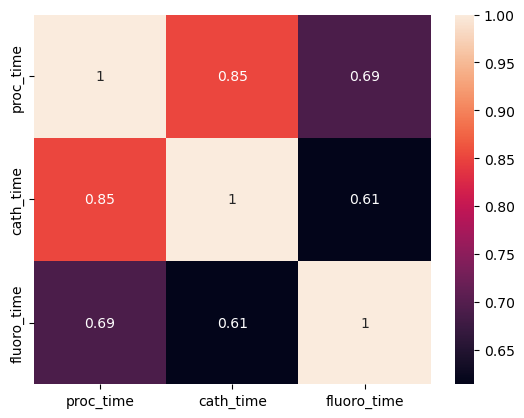

In [37]:
sns.heatmap(df_smote2.corr(),annot=True)

<AxesSubplot:ylabel='cath_time'>

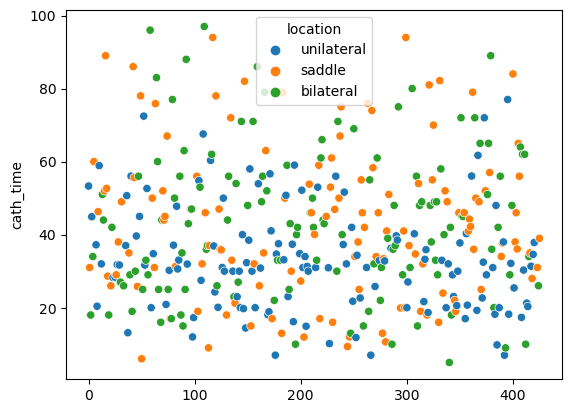

In [38]:
sns.scatterplot(data=df_smote2, x=df_smote2.index, y='cath_time',hue='location')

<AxesSubplot:ylabel='proc_time'>

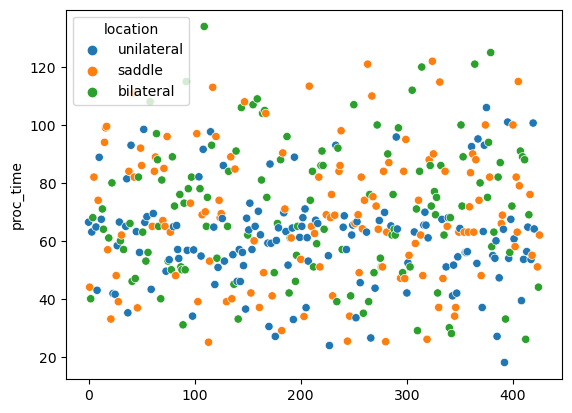

In [39]:
sns.scatterplot(data=df_smote2, x=df_smote2.index, y='proc_time',hue='location')

<AxesSubplot:ylabel='fluoro_time'>

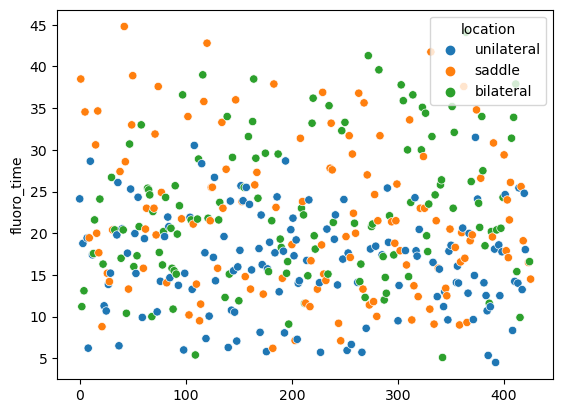

In [40]:
sns.scatterplot(data=df_smote2, x=df_smote2.index, y='fluoro_time',hue='location')

## Numeric Variables: Procedure Time, Catheter Time, Fluoroscopy Time

In [41]:
df.describe()

,proc_time,cath_time,fluoro_time,T20,Disks,missing
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,76.489510,48.646853,23.946678,0.444056,0.108392,0.384615
std,32.699561,28.014866,11.105162,0.497731,0.311419,0.487357
min,18.000000,5.000000,4.500000,0.000000,0.000000,0.000000
25%,55.000000,30.000000,15.800000,0.000000,0.000000,0.000000
50%,71.000000,44.000000,21.600000,0.000000,0.000000,0.000000
75%,90.750000,61.000000,30.675000,1.000000,0.000000,1.000000
max,237.000000,175.000000,72.100000,1.000000,1.000000,1.000000


<AxesSubplot:ylabel='cath_time'>

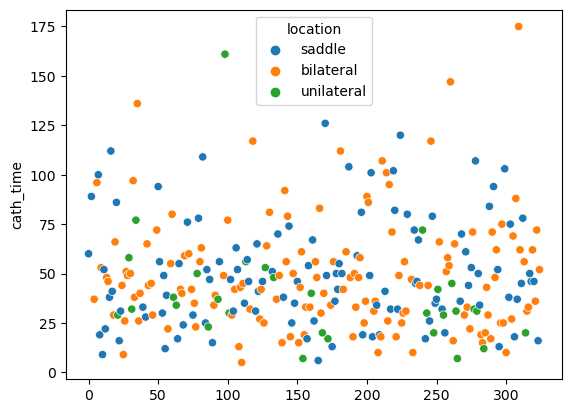

In [42]:
# find extreme outlier in cath_time which may due to a typo
sns.scatterplot(data=df, x=df.index, y='cath_time',hue='location')

<AxesSubplot:ylabel='proc_time'>

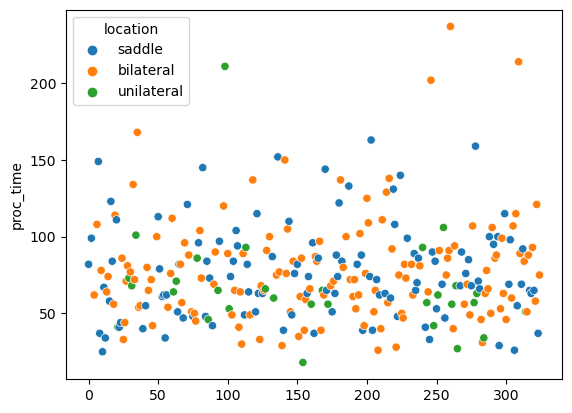

In [43]:
sns.scatterplot(data=df, x=df.index, y='proc_time',hue='location')

<AxesSubplot:ylabel='fluoro_time'>

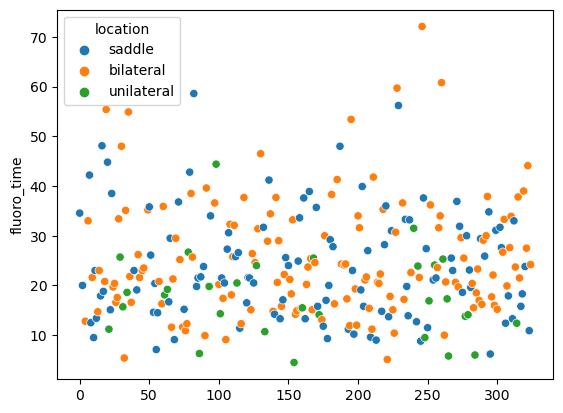

In [44]:
sns.scatterplot(data=df, x=df.index, y='fluoro_time',hue='location')

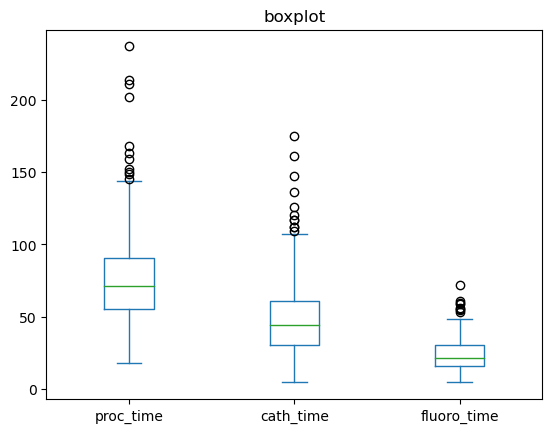

In [45]:
ax = df[['proc_time','cath_time','fluoro_time']].plot(kind='box', title='boxplot')

<AxesSubplot:>

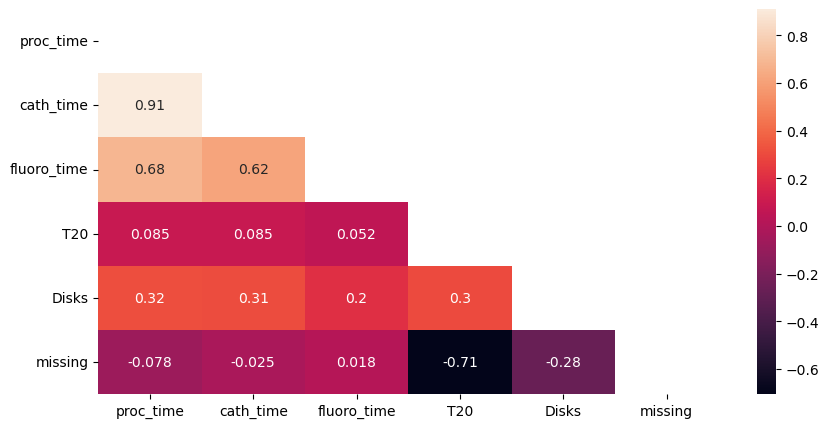

In [46]:
# correlation between cath_time and proc_time is 0.91
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True,mask=np.triu(df.corr()))

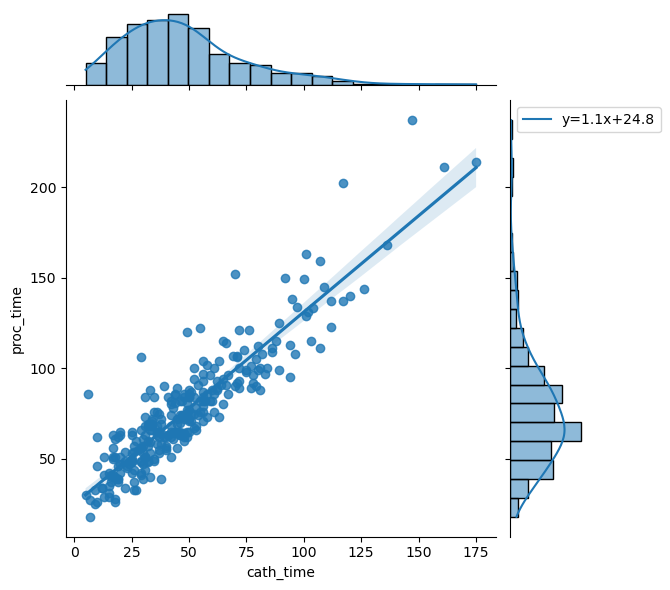

In [47]:
x,y = df['cath_time'],df['proc_time']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line_kws="y={0:.1f}x+{1:.1f}".format(slope,intercept)
g = sns.jointplot(data=df, x='cath_time', y='proc_time',kind='reg')
plt.legend(labels=[line_kws]);

Kruskal-Wallis hypothesis test

    The null hypothesis (H0): The median is the same for all the data groups.
    The alternative hypothesis: (Ha): The median is not equal for all the data groups.
    P-value: The probability of Null hypothesis being true
    Accept Null hypothesis if P-value>0.05 means variables are NOT correlated
    Reject Null hypothesis if P-value<0.05 means variables are correlated

In [48]:
# Homogeneity of variance Assumption Check
df_smote.groupby('location').std().max() / df_smote.groupby('location').std().min() # Passes

proc_time      1.273035
cath_time      1.283559
fluoro_time    1.621182
dtype: float64

In [49]:
# Normality Assumption Check
stats.shapiro(df_smote['fluoro_time']) # Fails

ShapiroResult(statistic=0.9321936368942261, pvalue=5.433992557139777e-13)

In [50]:
# kruskal wallis test (non-parametric alternative to one-way anova test)
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_smote[df_smote['location']=='saddle'][i]
    group2 = df_smote[df_smote['location']=='unilateral'][i]
    group3 = df_smote[df_smote['location']=='bilateral'][i]
    print(stats.kruskal(group1,group2,group3))

KruskalResult(statistic=22.575175477243118, pvalue=1.2527457299975938e-05)
KruskalResult(statistic=29.257155443899464, pvalue=4.4349570394587205e-07)
KruskalResult(statistic=47.98937114924022, pvalue=3.795250620461585e-11)


### Find correlation betweeen location(categorical) & catheter(categorical)

In [51]:
df.shape

(286, 7)

In [52]:
df['missing'].value_counts()

0    176
1    110
Name: missing, dtype: int64

In [53]:
df_drop_missing = df[df['missing'] == 0]
df_drop_missing = df_drop_missing.drop('missing',axis=1)
df_drop_missing.shape

(176, 6)

In [54]:
df_drop_missing['location'] = df_drop_missing['location'].map({'saddle':1,'bilateral':2,'unilateral':3})

In [55]:
from imblearn.over_sampling import SMOTENC
X, y =df_drop_missing[['proc_time','cath_time','fluoro_time','T20','Disks']], df_drop_missing['location']
smotenc = SMOTENC([3,4],random_state = 101)
X_smotenc, y_smotenc = smotenc.fit_resample(X, y)
df_smotenc = pd.concat([X_smotenc, y_smotenc], axis=1)
df_smotenc = df_smotenc.sample(frac=1).reset_index(drop=True)

In [56]:
df_smotenc

,proc_time,cath_time,fluoro_time,T20,Disks,location
0,51.000000,42.000000,11.600000,0,0,2
1,57.000000,26.000000,20.400000,0,1,2
2,73.000000,58.000000,25.700000,0,0,3
3,40.832877,16.167123,15.158493,1,0,1
4,62.000000,37.000000,12.800000,0,0,2
...,...,...,...,...,...,...
253,115.000000,88.000000,19.900000,1,1,2
254,47.034517,20.310651,21.282544,1,0,1
255,68.000000,31.000000,17.300000,0,0,3
256,59.359778,27.663130,13.584302,1,0,3


In [57]:
df_smotenc['location'] = df_smotenc['location'].map({1:'saddle',2:'bilateral',3:'unilateral'})

In [58]:
def function(a,b):
    if (a == 1) & (b == 0):
        return 'T20'
    elif (a == 0) & (b == 0):
        return 'T24'
    elif (a == 1) & (b == 1):
        return 'T20+Disks'
    elif (a == 0) & (b == 1):
        return 'T24+Disks'

In [59]:
df_smotenc['Procedure Type'] = df_smotenc.apply(lambda x: function(x['T20'],x['Disks']),axis=1)
df_smotenc.head()

,proc_time,cath_time,fluoro_time,T20,Disks,location,Procedure Type
0,51.000000,42.000000,11.600000,0,0,bilateral,T24
1,57.000000,26.000000,20.400000,0,1,bilateral,T24+Disks
2,73.000000,58.000000,25.700000,0,0,unilateral,T24
3,40.832877,16.167123,15.158493,1,0,saddle,T20
4,62.000000,37.000000,12.800000,0,0,bilateral,T24


In [63]:
df_smotenc['Procedure Type'].value_counts()

T20          180
T24           46
T20+Disks     28
T24+Disks      4
Name: Procedure Type, dtype: int64

### Chi Square Test:
    
    Used to check whether two categorical variables are related or not (independence check)
    Null Hypothesis: the two categorical variables are independent
    Alternative Hypothesis: the two categorical variables are not independent
    P-Value is the Probability of H0 being True
    Assumptions:
        - both variables are categorical
        - all observations are independent
        - cells in the contingency table are mutually exclusive
        - no assumption on expected distribution

In [64]:
CrosstabResult1=pd.crosstab(index=df_smotenc['location'],columns=df_smotenc['Procedure Type'])
print(CrosstabResult1)

Procedure Type  T20  T20+Disks  T24  T24+Disks
location                                      
bilateral        50         14   20          2
saddle           51         12   21          2
unilateral       79          2    5          0


In [65]:
ChiSqResult1 = chi2_contingency(CrosstabResult1)
print('The P-Value of the ChiSq Test is:', ChiSqResult1[1])
# variables are correlated

The P-Value of the ChiSq Test is: 3.344482542255082e-05


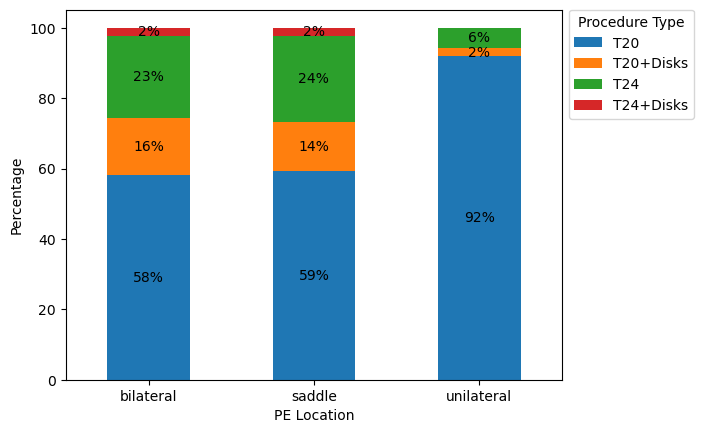

In [66]:
CrosstabResult1_prop=pd.crosstab(index=df_smotenc['location'],columns=df_smotenc['Procedure Type'],normalize='index').round(4)*100
ax_1 = CrosstabResult1_prop.plot.bar(stacked=True,rot=0)
for rec in ax_1.patches:
    height = rec.get_height()
    if height > 0 :
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center',
              va='center')
plt.xlabel('PE Location')
plt.ylabel('Percentage')
ax_1.legend(title='Procedure Type', bbox_to_anchor=(1, 1.02), loc='upper left');

In [67]:
CrosstabResult2=pd.crosstab(index=df_smotenc['location'],columns=df_smotenc['Aspiration'])
print(CrosstabResult2)

Aspiration  T20  T24
location            
bilateral    64   22
saddle       63   23
unilateral   81    5


In [68]:
ChiSqResult2 = chi2_contingency(CrosstabResult2)
print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])
# variables are correlated

The P-Value of the ChiSq Test is: 0.0004925268709866354


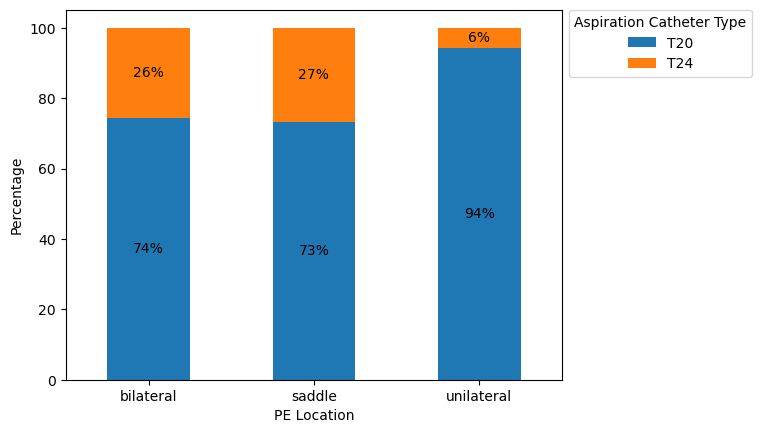

In [69]:
CrosstabResult2_prop=pd.crosstab(index=df_smotenc['location'],columns=df_smotenc['Aspiration'],normalize='index').round(4)*100
ax_2 = CrosstabResult2_prop.plot.bar(stacked=True,rot=0)
for rec in ax_2.patches:
    height = rec.get_height()
    if height > 0 :
        ax_2.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center',
              va='center')
plt.xlabel('PE Location')
plt.ylabel('Percentage')
ax_2.legend(title='Aspiration Catheter Type', bbox_to_anchor=(1, 1.02), loc='upper left');

In [70]:
CrosstabResult3=pd.crosstab(index=df_smotenc['location'],columns=df_smotenc['Disks'])
print(CrosstabResult3)

Disks        0   1
location          
bilateral   70  16
saddle      72  14
unilateral  84   2


In [71]:
ChiSqResult3 = chi2_contingency(CrosstabResult3)
print('The P-Value of the ChiSq Test is:', ChiSqResult3[1])
# variables are correlated

The P-Value of the ChiSq Test is: 0.002163426553443425


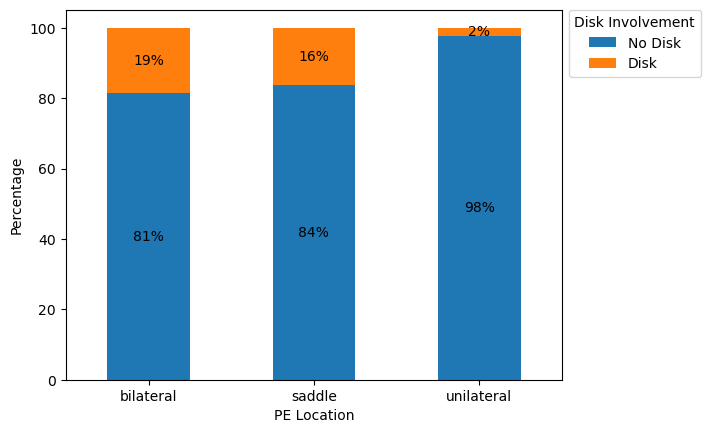

In [72]:
CrosstabResult3_prop=pd.crosstab(index=df_smotenc['location'],columns=df_smotenc['Disks'],normalize='index').round(4)*100
ax_3 = CrosstabResult3_prop.plot.bar(stacked=True,rot=0)
for rec in ax_3.patches:
    height = rec.get_height()
    if height > 0 :
        ax_3.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center',
              va='center')
plt.xlabel('PE Location')
plt.ylabel('Percentage')
ax_3.legend(['No Disk','Disk'],title='Disk Involvement', bbox_to_anchor=(1, 1.02), loc='upper left');

In [79]:
CrosstabResult4=pd.crosstab(index=df_smotenc['T20'],columns=df_smotenc['Disks'])
print(CrosstabResult4)

Disks    0   1
T20           
0       46   4
1      180  28


In [80]:
print(stats.fisher_exact(CrosstabResult4))

(1.788888888888889, 0.3490210906737655)


In [81]:
ChiSqResult4 = chi2_contingency(CrosstabResult4)
print('The P-Value of the ChiSq Test is:', ChiSqResult4[1])

The P-Value of the ChiSq Test is: 0.41617732686432785


In [87]:
df_2cat = df_smotenc[df_smotenc['location']!='bilateral']

In [88]:
CrosstabResult4=pd.crosstab(index=df_2cat['location'],columns=df_2cat['T20'])
print(CrosstabResult4)

T20          0   1
location          
saddle      23  63
unilateral   5  81


In [89]:
print(stats.fisher_exact(CrosstabResult4))

(5.914285714285715, 0.00030822180109262075)


In [90]:
CrosstabResult5=pd.crosstab(index=df_2cat['location'],columns=df_2cat['Disks'])
print(CrosstabResult5)

Disks        0   1
location          
saddle      72  14
unilateral  84   2


In [91]:
print(stats.fisher_exact(CrosstabResult5))

(0.12244897959183673, 0.002718005175658536)


In [ ]:
sns.pairplot(data=df_smote,hue='location')

In [ ]:
sns.scatterplot(data=df_smote, x='proc_time', y='fluoro_time', hue='location')